<a href="https://colab.research.google.com/github/tejasr42/nma/blob/solutions/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 1, Day 2, Tutorial 2
# Modeling Practice: Model implementation and evaluation
__Content creators:__ Marius 't Hart, Paul Schrater, Gunnar Blohm

__Content reviewers:__ Norma Kuhn, Saeed Salehi, Madineh Sarvestani, Spiros Chavlis, Michael Waskom

---
# Tutorial objectives

We are investigating a simple phenomena, working through the 10 steps of modeling ([Blohm et al., 2019](https://doi.org/10.1523/ENEURO.0352-19.2019)) in two notebooks: 

**Framing the question**

1. finding a phenomenon and a question to ask about it
2. understanding the state of the art
3. determining the basic ingredients
4. formulating specific, mathematically defined hypotheses

**Implementing the model**

5. selecting the toolkit
6. planning the model
7. implementing the model

**Model testing**

8. completing the model
9. testing and evaluating the model

**Publishing**

10. publishing models

We did steps 1-5 in Tutorial 1 and will cover steps 6-10 in Tutorial 2 (this notebook).

# Setup



In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gamma
from IPython.display import YouTubeVideo

In [21]:
# @title Figure settings
import ipywidgets as widgets

%config InlineBackend.figure_format = 'retina'

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [22]:
# @title Helper functions


def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
        x (numpy.ndarray): a vector array of size N
        window (int): size of the window, must be a positive integer
        FUN (function): the function to apply to the samples in the window

    Returns:
        (numpy.ndarray): a vector array of size N, containing the moving
        average of x, calculated with a window of size window

    There are smarter and faster solutions (e.g. using convolution) but this
    function shows what the output really means. This function skips NaNs, and
    should not be susceptible to edge effects: it will simply use
    all the  available samples, which means that close to the edges of the
    signal or close to NaNs, the output will just be based on fewer samples. By
    default, this function will apply a mean to the samples in the window, but
    this can be changed to be a max/min/median or other function that returns a
    single numeric value based on a sequence of values.
    """

    # if data is a matrix, apply filter to each row:
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],
                                               window=window, FUN=FUN)
        return output

    # make output array of the same size as x:
    output = np.zeros(x.size)

    # loop through the signal in x
    for samp_i in range(x.size):

        values = []

        # loop through the window:
        for wind_i in range(int(1 - window), 1):

            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue

            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]

        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)

    return output


def my_plot_percepts(datasets=None, plotconditions=False):

    if isinstance(datasets, dict):
        # try to plot the datasets
        # they should be named...
        # 'expectations', 'judgments', 'predictions'

        plt.figure(figsize=(8, 8))  # set aspect ratio = 1? not really

        plt.ylabel('perceived self motion [m/s]')
        plt.xlabel('perceived world motion [m/s]')
        plt.title('perceived velocities')

        # loop through the entries in datasets
        # plot them in the appropriate way
        for k in datasets.keys():
            if k == 'expectations':

                expect = datasets[k]
                plt.scatter(expect['world'], expect['self'], marker='*',
                            color='xkcd:green', label='my expectations')

            elif k == 'judgments':

                judgments = datasets[k]

                for condition in np.unique(judgments[:, 0]):
                    c_idx = np.where(judgments[:, 0] == condition)[0]
                    cond_self_motion = judgments[c_idx[0], 1]
                    cond_world_motion = judgments[c_idx[0], 2]
                    if cond_world_motion == -1 and cond_self_motion == 0:
                        c_label = 'world-motion condition judgments'
                    elif cond_world_motion == 0 and cond_self_motion == 1:
                        c_label = 'self-motion condition judgments'
                    else:
                        c_label = f"condition [{condition:d}] judgments"

                    plt.scatter(judgments[c_idx, 3], judgments[c_idx, 4],
                                label=c_label, alpha=0.2)

            elif k == 'predictions':

                predictions = datasets[k]

                for condition in np.unique(predictions[:, 0]):
                    c_idx = np.where(predictions[:, 0] == condition)[0]
                    cond_self_motion = predictions[c_idx[0], 1]
                    cond_world_motion = predictions[c_idx[0], 2]
                    if cond_world_motion == -1 and cond_self_motion == 0:
                        c_label = 'predicted world-motion condition'
                    elif cond_world_motion == 0 and cond_self_motion == 1:
                        c_label = 'predicted self-motion condition'
                    else:
                        c_label = f"condition [{condition:d}] prediction"

                    plt.scatter(predictions[c_idx, 4], predictions[c_idx, 3],
                                marker='x', label=c_label)

            else:
                print("datasets keys should be 'hypothesis', \
                'judgments' and 'predictions'")

        if plotconditions:
            # this code is simplified but only works for the dataset we have:
            plt.scatter([1], [0], marker='<', facecolor='none',
                        edgecolor='xkcd:black', linewidths=2,
                        label='world-motion stimulus', s=80)
            plt.scatter([0], [1], marker='>', facecolor='none',
                        edgecolor='xkcd:black', linewidths=2,
                        label='self-motion stimulus', s=80)

        plt.legend(facecolor='xkcd:white')
        plt.show()

    else:
        if datasets is not None:
            print('datasets argument should be a dict')
            raise TypeError


def my_plot_stimuli(t, a, v):
    plt.figure(figsize=(10, 6))
    plt.plot(t, a, label='acceleration [$m/s^2$]')
    plt.plot(t, v, label='velocity [$m/s$]')
    plt.xlabel('time [s]')
    plt.ylabel('[motion]')
    plt.legend(facecolor='xkcd:white')
    plt.show()


def my_plot_motion_signals():
    dt = 1 / 10
    a = gamma.pdf(np.arange(0, 10, dt), 2.5, 0)
    t = np.arange(0, 10, dt)
    v = np.cumsum(a * dt)

    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharex='col',
                                   sharey='row', figsize=(14, 6))
    fig.suptitle('Sensory ground truth')

    ax1.set_title('world-motion condition')
    ax1.plot(t, -v, label='visual [$m/s$]')
    ax1.plot(t, np.zeros(a.size), label='vestibular [$m/s^2$]')
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('motion')
    ax1.legend(facecolor='xkcd:white')

    ax2.set_title('self-motion condition')
    ax2.plot(t, -v, label='visual [$m/s$]')
    ax2.plot(t, a, label='vestibular [$m/s^2$]')
    ax2.set_xlabel('time [s]')
    ax2.set_ylabel('motion')
    ax2.legend(facecolor='xkcd:white')

    plt.show()


def my_plot_sensorysignals(judgments, opticflow, vestibular, returnaxes=False,
                           addaverages=False, integrateVestibular=False,
                           addGroundTruth=False):

    if addGroundTruth:
        dt = 1 / 10
        a = gamma.pdf(np.arange(0, 10, dt), 2.5, 0)
        t = np.arange(0, 10, dt)
        v = a

    wm_idx = np.where(judgments[:, 0] == 0)
    sm_idx = np.where(judgments[:, 0] == 1)

    opticflow = opticflow.transpose()
    wm_opticflow = np.squeeze(opticflow[:, wm_idx])
    sm_opticflow = np.squeeze(opticflow[:, sm_idx])

    if integrateVestibular:
        vestibular = np.cumsum(vestibular * .1, axis=1)
        if addGroundTruth:
            v = np.cumsum(a * dt)

    vestibular = vestibular.transpose()
    wm_vestibular = np.squeeze(vestibular[:, wm_idx])
    sm_vestibular = np.squeeze(vestibular[:, sm_idx])

    X = np.arange(0, 10, .1)

    fig, my_axes = plt.subplots(nrows=2, ncols=2, sharex='col',
                                sharey='row', figsize=(15, 10))
    fig.suptitle('Sensory signals')

    my_axes[0][0].plot(X, wm_opticflow, color='xkcd:light red', alpha=0.1)
    my_axes[0][0].plot([0, 10], [0, 0], ':', color='xkcd:black')
    if addGroundTruth:
        my_axes[0][0].plot(t, -v, color='xkcd:red')
    if addaverages:
        my_axes[0][0].plot(X, np.average(wm_opticflow, axis=1),
                           color='xkcd:red', alpha=1)
    my_axes[0][0].set_title('optic-flow in world-motion condition')
    my_axes[0][0].set_ylabel('velocity signal [$m/s$]')

    my_axes[0][1].plot(X, sm_opticflow, color='xkcd:azure', alpha=0.1)
    my_axes[0][1].plot([0, 10], [0, 0], ':', color='xkcd:black')
    if addGroundTruth:
        my_axes[0][1].plot(t, -v, color='xkcd:blue')
    if addaverages:
        my_axes[0][1].plot(X, np.average(sm_opticflow, axis=1),
                           color='xkcd:blue', alpha=1)
    my_axes[0][1].set_title('optic-flow in self-motion condition')

    my_axes[1][0].plot(X, wm_vestibular, color='xkcd:light red', alpha=0.1)
    my_axes[1][0].plot([0, 10], [0, 0], ':', color='xkcd:black')
    if addaverages:
        my_axes[1][0].plot(X, np.average(wm_vestibular, axis=1),
                           color='xkcd:red', alpha=1)
    my_axes[1][0].set_title('vestibular signal in world-motion condition')
    if addGroundTruth:
        my_axes[1][0].plot(t, np.zeros(100), color='xkcd:red')
    my_axes[1][0].set_xlabel('time [s]')
    if integrateVestibular:
        my_axes[1][0].set_ylabel('velocity signal [$m/s$]')
    else:
        my_axes[1][0].set_ylabel('acceleration signal [$m/s^2$]')

    my_axes[1][1].plot(X, sm_vestibular, color='xkcd:azure', alpha=0.1)
    my_axes[1][1].plot([0, 10], [0, 0], ':', color='xkcd:black')
    if addGroundTruth:
        my_axes[1][1].plot(t, v, color='xkcd:blue')
    if addaverages:
        my_axes[1][1].plot(X, np.average(sm_vestibular, axis=1),
                           color='xkcd:blue', alpha=1)
    my_axes[1][1].set_title('vestibular signal in self-motion condition')
    my_axes[1][1].set_xlabel('time [s]')

    if returnaxes:
        return my_axes
    else:
        plt.show()


def my_threshold_solution(selfmotion_vel_est, threshold):
    is_move = (selfmotion_vel_est > threshold)
    return is_move


def my_moving_threshold(selfmotion_vel_est, thresholds):

    pselfmove_nomove = np.empty(thresholds.shape)
    pselfmove_move = np.empty(thresholds.shape)
    prop_correct = np.empty(thresholds.shape)
    pselfmove_nomove[:] = np.NaN
    pselfmove_move[:] = np.NaN
    prop_correct[:] = np.NaN

    for thr_i, threshold in enumerate(thresholds):

        # run my_threshold that the students will write:
        try:
            is_move = my_threshold(selfmotion_vel_est, threshold)
        except Exception:
            is_move = my_threshold_solution(selfmotion_vel_est, threshold)

        # store results:
        pselfmove_nomove[thr_i] = np.mean(is_move[0:100])
        pselfmove_move[thr_i] = np.mean(is_move[100:200])

        # calculate the proportion classified correctly:
        # (1-pselfmove_nomove) + ()
        # Correct rejections:
        p_CR = (1 - pselfmove_nomove[thr_i])
        # correct detections:
        p_D = pselfmove_move[thr_i]

        # this is corrected for proportion of trials in each condition:
        prop_correct[thr_i] = (p_CR + p_D) / 2

    return [pselfmove_nomove, pselfmove_move, prop_correct]


def my_plot_thresholds(thresholds, world_prop, self_prop, prop_correct):

    plt.figure(figsize=(12, 8))
    plt.title('threshold effects')
    plt.plot([min(thresholds), max(thresholds)], [0, 0], ':',
             color='xkcd:black')
    plt.plot([min(thresholds), max(thresholds)], [0.5, 0.5], ':',
             color='xkcd:black')
    plt.plot([min(thresholds), max(thresholds)], [1, 1], ':',
             color='xkcd:black')
    plt.plot(thresholds, world_prop, label='world motion condition')
    plt.plot(thresholds, self_prop, label='self motion condition')
    plt.plot(thresholds, prop_correct, color='xkcd:purple',
             label='correct classification')
    plt.xlabel('threshold')
    plt.ylabel('proportion correct or classified as self motion')
    plt.legend(facecolor='xkcd:white')
    plt.show()


def my_plot_predictions_data(judgments, predictions):

    # conditions = np.concatenate((np.abs(judgments[:, 1]),
    #                              np.abs(judgments[:, 2])))
    # veljudgmnt = np.concatenate((judgments[:, 3], judgments[:, 4]))
    # velpredict = np.concatenate((predictions[:, 3], predictions[:, 4]))

    # self:
    # conditions_self = np.abs(judgments[:, 1])
    veljudgmnt_self = judgments[:, 3]
    velpredict_self = predictions[:, 3]

    # world:
    # conditions_world = np.abs(judgments[:, 2])
    veljudgmnt_world = judgments[:, 4]
    velpredict_world = predictions[:, 4]

    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, sharey='row',
                                   figsize=(12, 5))

    ax1.scatter(veljudgmnt_self, velpredict_self, alpha=0.2)
    ax1.plot([0, 1], [0, 1], ':', color='xkcd:black')
    ax1.set_title('self-motion judgments')
    ax1.set_xlabel('observed')
    ax1.set_ylabel('predicted')

    ax2.scatter(veljudgmnt_world, velpredict_world, alpha=0.2)
    ax2.plot([0, 1], [0, 1], ':', color='xkcd:black')
    ax2.set_title('world-motion judgments')
    ax2.set_xlabel('observed')
    ax2.set_ylabel('predicted')

    plt.show()

In [23]:
# @title Data retrieval
import os
fname="W1D2_data.npz"
if not os.path.exists(fname):
  !wget https://osf.io/c5xyf/download -O $fname

filez = np.load(file=fname, allow_pickle=True)
judgments = filez['judgments']
opticflow = filez['opticflow']
vestibular = filez['vestibular']

---
# Section 6: Model planning

Video available at https://youtube.com/watch?v=dRTOFFigxa0


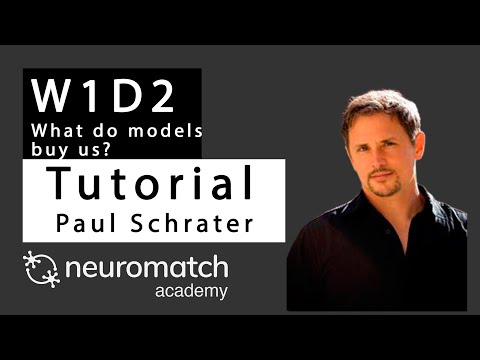

In [24]:
# @title Video 6: Planning
video = YouTubeVideo(id='dRTOFFigxa0', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video


**Goal:** Identify the key components of the model and how they work together.

Our goal all along has been to model our perceptual estimates of sensory data.
Now that we have some idea of what we want to do, we need to line up the components of the model: what are the input and output? Which computations are done and in what order? 

Our model will have:
* **inputs**: the values the system has available - this can be broken down in _data:_ the sensory signals, _parameters:_ the threshold and the window sizes for filtering
* **outputs**: these are the predictions our model will make - for this tutorial these are the perceptual judgments on each trial in m/s, just like the judgments participants made.
* **model functions**: A set of functions that perform the hypothesized computations.

We will define a set of functions that take our data and some parameters as input, can run our model, and output a prediction for the judgment data.

**Recap of what we've accomplished so far:**

To model perceptual estimates from our sensory data, we need to 
1. _integrate:_ to ensure sensory information are in appropriate units
2. _filter:_ to reduce noise and set timescale
3. _threshold:_ to model detection

This will be done with these operations:
1. _integrate:_ `np.cumsum()`
2. _filter:_ `my_moving_window()`
3. _threshold:_ `if` with a comparison (`>` or `<`) and `else`

**_Planning our model:_**

We will now start putting all the pieces together. Normally you would sketch this yourself, but here is an overview of how the functions comprising the model are going to work:

![model functions purpose](https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/NMA-W1D2-fig05.png)

Below is the main function with a detailed explanation of what the function is supposed to do, exactly what input is expected, and what output will be generated. 

The model is not complete, so it only returns nans (**n**ot-**a**-**n**umber) for now. However, this outlines how most model code works: it gets some measured data (the sensory signals) and a set of parameters as input, and as output returns a prediction on other measured data (the velocity judgments). 

The goal of this function is to define the top level of a simulation model which:
* receives all input
* loops through the cases
* calls functions that computes predicted values for each case
* outputs the predictions

**Main model function**

In [25]:
def my_train_illusion_model(sensorydata, params):
  """
  Generate output predictions of perceived self-motion and perceived
  world-motion velocity based on input visual and vestibular signals.

  Args:

    sensorydata: (dict) dictionary with two named entries:
        opticflow: (numpy.ndarray of float) NxM array with N trials on rows
                   and M visual signal samples in columns

        vestibular: (numpy.ndarray of float) NxM array with N trials on rows
                    and M vestibular signal samples in columns

    params: (dict) dictionary with named entries:
        threshold: (float) vestibular threshold for credit assignment

        filterwindow: (list of int) determines the strength of filtering for
                      the visual and vestibular signals, respectively

        integrate (bool): whether to integrate the vestibular signals, will
                          be set to True if absent

        FUN (function): function used in the filter, will be set to
                        np.mean if absent

        samplingrate (float): the number of samples per second in the
                              sensory data, will be set to 10 if absent

  Returns:

    dict with two entries:

      selfmotion: (numpy.ndarray) vector array of length N, with predictions
                  of perceived self motion

      worldmotion: (numpy.ndarray) vector array of length N, with predictions
                   of perceived world motion
  """

  # sanitize input a little
  if not('FUN' in params.keys()):
      params['FUN'] = np.mean
  if not('integrate' in params.keys()):
      params['integrate'] = True
  if not('samplingrate' in params.keys()):
      params['samplingrate'] = 10

  # number of trials:
  ntrials = sensorydata['opticflow'].shape[0]

  # set up variables to collect output
  selfmotion = np.empty(ntrials)
  worldmotion = np.empty(ntrials)

  # loop through trials?
  for trialN in range(ntrials):

      # these are our sensory variables (inputs)
      vis = sensorydata['opticflow'][trialN, :]
      ves = sensorydata['vestibular'][trialN, :]

      # generate output predicted perception:
      selfmotion[trialN],\
        worldmotion[trialN] = my_perceived_motion(vis=vis, ves=ves,
                                                  params=params)

  return {'selfmotion': selfmotion, 'worldmotion': worldmotion}


# here is a mock version of my_perceived motion.
# so you can test my_train_illusion_model()
def my_perceived_motion(*args, **kwargs):
  return [np.nan, np.nan]


# let's look at the preditions we generated for two sample trials (0,100)
# we should get a 1x2 vector of self-motion prediction and another
# for world-motion

sensorydata={'opticflow': opticflow[[0, 100], :0],
             'vestibular': vestibular[[0, 100], :0]}
params={'threshold': 0.33, 'filterwindows': [100, 50]}
my_train_illusion_model(sensorydata=sensorydata, params=params)

{'selfmotion': array([nan, nan]), 'worldmotion': array([nan, nan])}

We've also completed the `my_perceived_motion()` function for you below. Follow this example to complete the template for `my_selfmotion()` and `my_worldmotion()`. Write out the inputs and outputs, and the steps required to calculate the outputs from the inputs.

**Perceived motion function**

In [26]:
# Full perceived motion function


def my_perceived_motion(vis, ves, params):
  """
  Takes sensory data and parameters and returns predicted percepts

  Args:
      vis (numpy.ndarray) : 1xM array of optic flow velocity data
      ves (numpy.ndarray) : 1xM array of vestibular acceleration data
      params              : (dict) dictionary with named entries:
                            see my_train_illusion_model() for details

  Returns:
      [list of floats]    : prediction for perceived self-motion based on
                            vestibular data, and prediction for perceived
                            world-motion based on perceived self-motion and
                            visual data
  """

  # estimate self motion based on only the vestibular data
  # pass on the parameters
  selfmotion = my_selfmotion(ves=ves, params=params)

  # estimate the world motion, based on the selfmotion and visual data
  # pass on the parameters as well
  worldmotion = my_worldmotion(vis=vis, selfmotion=selfmotion, params=params)

  return [selfmotion, worldmotion]

## TD 6.1: Formulate purpose of the self motion function

Now we plan out the purpose of one of the remaining functions. **Only name input arguments, write help text and comments, _no code_.** The goal of this exercise is to make writing the code (in Micro-tutorial 7) much easier. Based on our work before the break, you should now be able to answer these questions for each function:

* what (sensory) data is necessary? 
* what parameters does the function need, if any?
* which operations will be performed on the input?
* what is the output?

The number of arguments is correct.

**Template calculate self motion**

Name the _input arguments_, complete the _help text_, and add _comments_ in the function below to describe the inputs, the outputs, and operations using elements from the recap at the top of this notebook (or from micro-tutorials 3 and 4 in part 1), in order to plan out the function. Do not write any code.

In [27]:
def my_selfmotion(ves, arg2):
    """
    Short description of the function

    Args:
        ves (numpy.ndarray) : 1xM array of vestibular acceleration data
        params              : (dict) dictionary with named entries:
                              see my_train_illusion_model() for details
    Returns:
        float               : estimate of velocity of own motion

    Any further description?
    """

    # what operations do we perform on the input?
    # use the elements from micro-tutorials 3, 4, and 5
    # 1. integrate input
    # 2. get moving average
    # 3. take final value
    # 4. compare against threshold

    # what output should this function produce?
    return output

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial2_Solution_90e4d753.py)



**Template calculate world motion**

We have drafted the help text and written comments in the function below that describe the inputs, the outputs, and operations we use to estimate world motion, based on the recap above.

In [28]:
# World motion function


def my_worldmotion(vis, selfmotion, params):
    """
    Estimates world motion based on the visual signal, the estimate of

    Args:
        vis (numpy.ndarray): 1xM array with the optic flow signal
        selfmotion (float): estimate of self motion
        params (dict): dictionary with named entries:
            see my_train_illusion_model() for details

    Returns:
        (float): an estimate of world motion in m/s
    """

    # 1. running window function
    # 2. take final value
    # 3. subtract selfmotion from value

    # return final value
    return output

---
# Section 7: Model implementation

Video available at https://youtube.com/watch?v=DMSIt7t-LO8


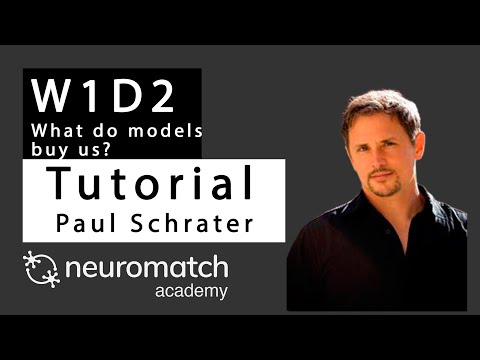

In [29]:
# @title Video 7: Implementation
video = YouTubeVideo(id='DMSIt7t-LO8', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video


**Goal:** We write the components of the model in actual code.

For the operations we picked, there function ready to use:
* integration: `np.cumsum(data, axis=1)` (axis=1: per trial and over samples)
* filtering: `my_moving_window(data, window)` (window: int, default 3)
* take last `selfmotion` value as our estimate
* threshold: if (value > thr): <operation 1> else: <operation 2>



## TD 7.1: Write code to estimate self motion

Use the operations to finish writing the function that will calculate an estimate of self motion. Fill in the descriptive list of items with actual operations. Use the function for estimating world-motion below, which we've filled for you!


### Exercise 1: finish self motion function

In [30]:
# Self motion function


def my_selfmotion(ves, params):
    """
    Estimates self motion for one vestibular signal

    Args:
        ves (numpy.ndarray): 1xM array with a vestibular signal
        params (dict)      : dictionary with named entries:
                             see my_train_illusion_model() for details

    Returns:
        (float)            : an estimate of self motion in m/s
    """

    # uncomment the code below and fill in with your code

    # 1. integrate vestibular signal
    ves = np.cumsum(ves * (1 / params['samplingrate']))

    # 2. running window function to accumulate evidence:
    selfmotion = my_moving_window(ves,window=params['filterwindows'][1],
                                    FUN=params['FUN'])

    # 3. take final value of self-motion vector as our estimate
    selfmotion = selfmotion[-1]

    # 4. compare to threshold. Hint the threshold is stored in
    # params['threshold']
    # if selfmotion is higher than threshold: return value
    # if it's lower than threshold: return 0

    output = (selfmotion>params['threshold'])*selfmotion

    # Comment this line when your function is ready
    # raise NotImplementedError("Student excercise: estimate my_selfmotion")

    return output

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial2_Solution_53312239.py)



### Interactive Demo: Unit testing

Testing if the functions you wrote do what they are supposed to do is important, and known as 'unit testing'. Here we will simplify this for the `my_selfmotion()` function, by allowing varying the threshold and window size with a slider, and seeing what the distribution of self-motion estimates looks like.

In [31]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

def refresh(threshold=0, windowsize=100):

    params = {'samplingrate': 10, 'FUN': np.mean}
    params['filterwindows'] = [windowsize, 50]
    params['threshold'] = threshold

    selfmotion_estimates = np.empty(200)

    # get the estimates for each trial:
    for trial_number in range(200):
        ves = vestibular[trial_number, :]
        selfmotion_estimates[trial_number] = my_selfmotion(ves, params)

    plt.figure()
    plt.hist(selfmotion_estimates, bins=20)
    plt.xlabel('self-motion estimate')
    plt.ylabel('frequency')
    plt.show()


_ = widgets.interact(refresh, threshold=(-1, 2, .01), windowsize=(1, 100, 1))

interactive(children=(FloatSlider(value=0.0, description='threshold', max=2.0, min=-1.0, step=0.01), IntSlider…

**Estimate world motion**

We have completed the `my_worldmotion()` function for you below.



In [32]:
# World motion function
def my_worldmotion(vis, selfmotion, params):
    """
    Short description of the function

    Args:
        vis (numpy.ndarray): 1xM array with the optic flow signal
        selfmotion (float): estimate of self motion
        params (dict): dictionary with named entries:
            see my_train_illusion_model() for details

    Returns:
        (float): an estimate of world motion in m/s
    """

    # running average to smooth/accumulate sensory evidence
    visualmotion = my_moving_window(vis, window=params['filterwindows'][0],
                                    FUN=np.mean)

    # take final value
    visualmotion = visualmotion[-1]

    # subtract selfmotion from value
    worldmotion = visualmotion + selfmotion

    # return final value
    return worldmotion

---
# Section 8: Model completion

Video available at https://youtube.com/watch?v=EM-G8YYdrDg


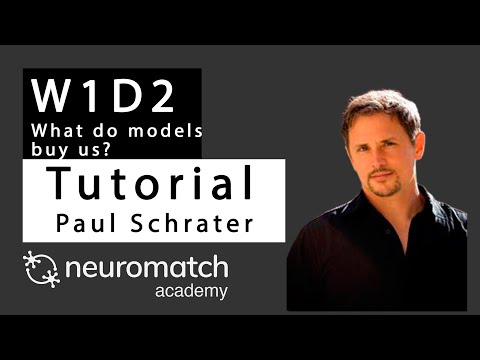

In [33]:
# @title Video 8: Completion
video = YouTubeVideo(id='EM-G8YYdrDg', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video


**Goal:** Make sure the model can speak to the hypothesis. Eliminate all the parameters that do not speak to the hypothesis.

Now that we have a working model, we can keep improving it, but at some point we need to decide that it is finished. Once we have a model that displays the properties of a system we are interested in, it should be possible to say something about our hypothesis and question. Keeping the model simple makes it easier to understand the phenomenon and answer the research question. Here that means that our model should have illusory perception, and perhaps make similar judgments to those of the participants, but not much more.

To test this, we will run the model, store the output and plot the models' perceived self motion over perceived world motion, like we did with the actual perceptual judgments (it even uses the same plotting function).

## TD 8.1: See if the model produces illusions

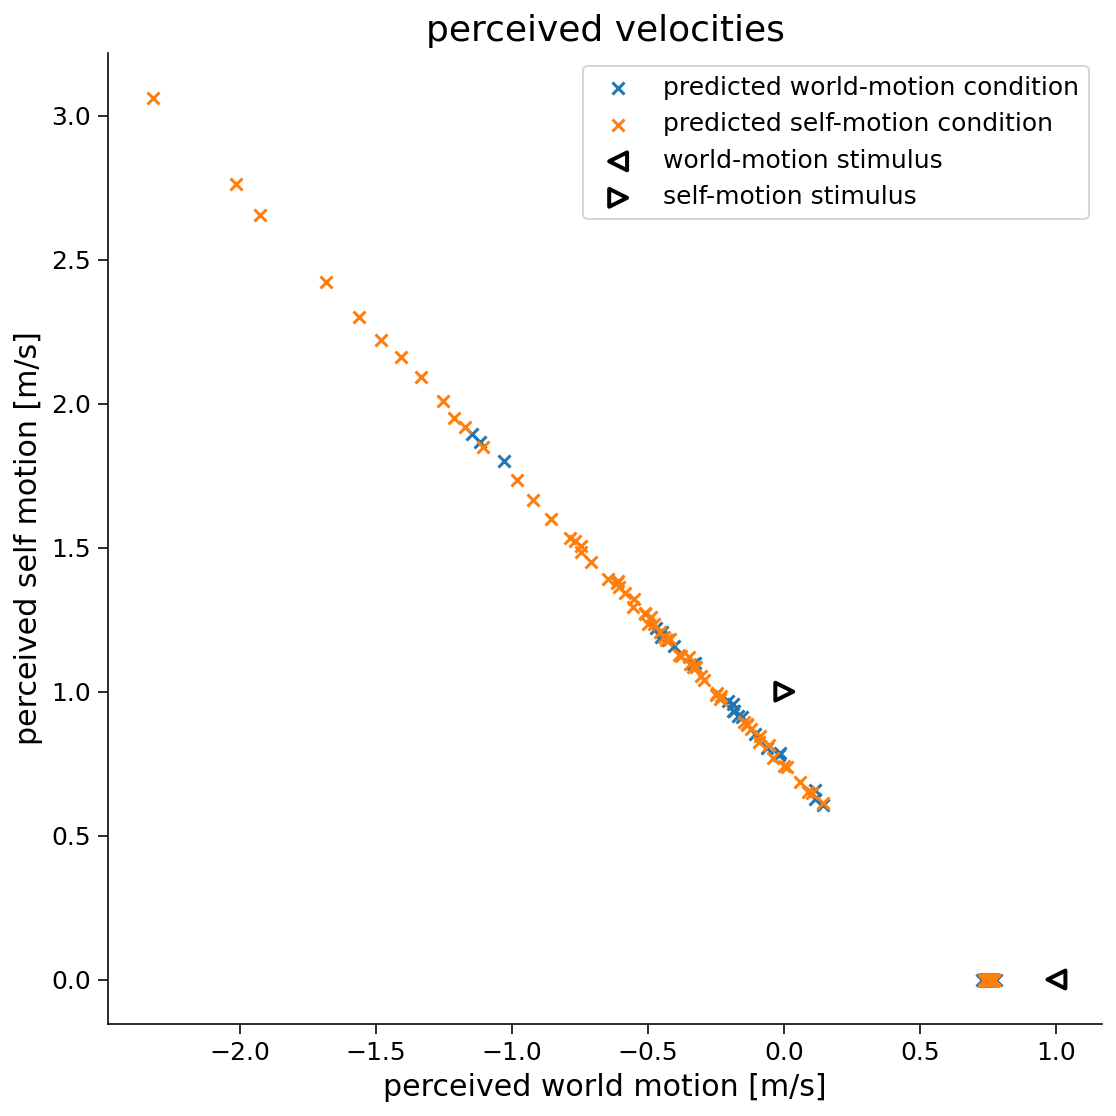

In [34]:
# @markdown Run to plot model predictions of motion estimates
# prepare to run the model again:
data = {'opticflow': opticflow, 'vestibular': vestibular}
params = {'threshold': 0.6, 'filterwindows': [100, 50], 'FUN': np.mean}
modelpredictions = my_train_illusion_model(sensorydata=data, params=params)

# process the data to allow plotting...
predictions = np.zeros(judgments.shape)
predictions[:, 0:3] = judgments[:, 0:3]
predictions[:, 3] = modelpredictions['selfmotion']
predictions[:, 4] = modelpredictions['worldmotion'] * -1
my_plot_percepts(datasets={'predictions': predictions}, plotconditions=True)

**Questions:**

* How does the distribution of data points compare to the plot in TD 1.2 or in TD 7.1?
* Did you expect to see this?
* Where do the model's predicted judgments for each of the two conditions fall?
* How does this compare to the behavioral data?

However, the main observation should be that **there are illusions**: the blue and red data points are mixed in each of the two clusters of data points. This mean the model can help us understand the phenomenon.

---
# Section 9: Model evaluation

Video available at https://youtube.com/watch?v=bWLFyobm4Rk


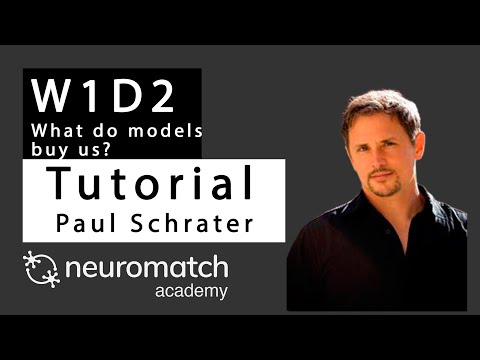

In [35]:
# @title Video 9: Evaluation
video = YouTubeVideo(id='bWLFyobm4Rk', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video


**Goal:** Once we have finished the model, we need a description of how good it is. The question and goals we set in micro-tutorial 1 and 4 help here. There are multiple ways to evaluate a model. Aside from the obvious fact that we want to get insight into the phenomenon that is not directly accessible without the model, we always want to quantify how well the model agrees with the data.

**Quantify model quality with $R^2$**

Let's look at how well our model matches the actual judgment data.

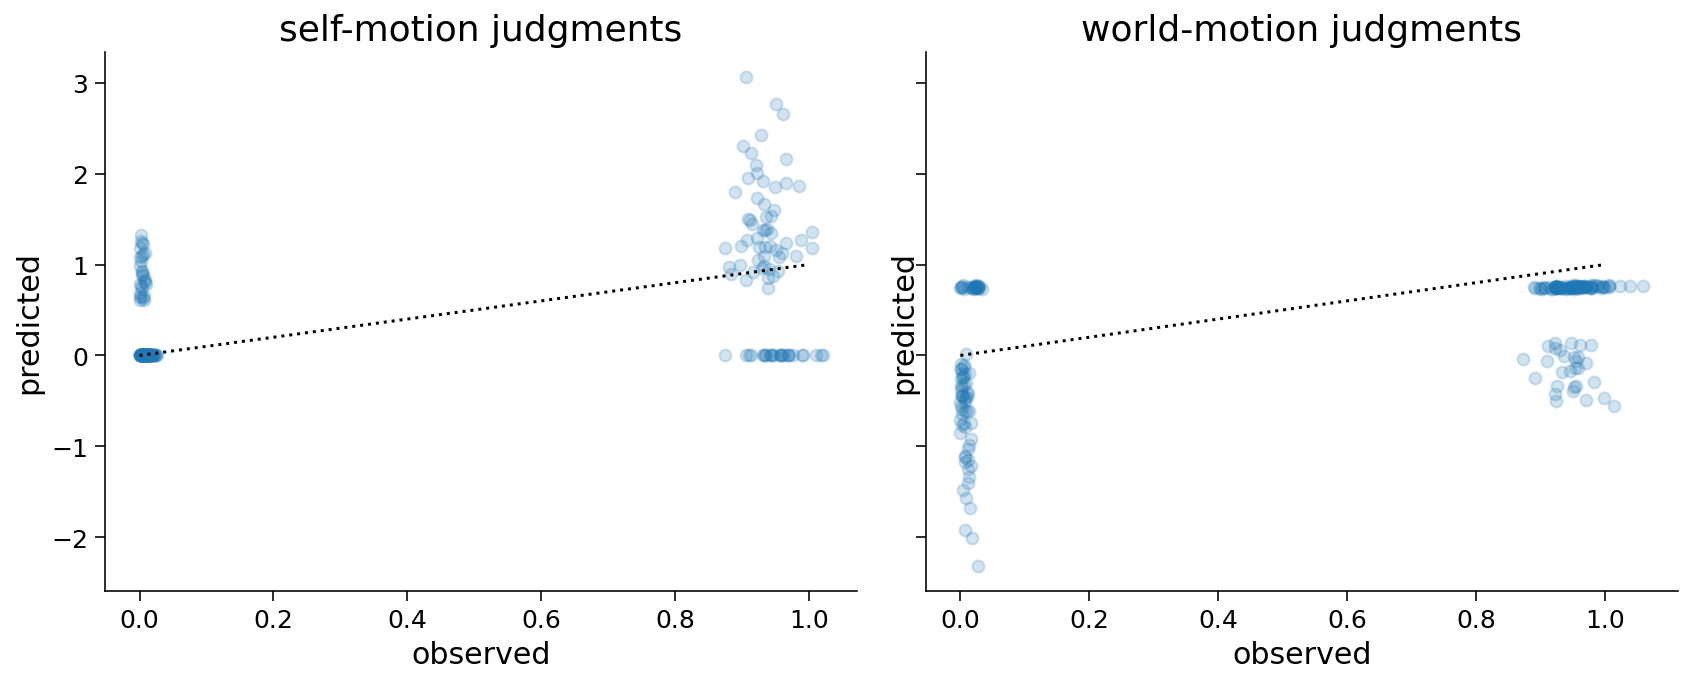

In [36]:
# @markdown Run to plot predictions over data
my_plot_predictions_data(judgments, predictions)

When model predictions are correct, the red points in the figure above should lie along the identity line (a dotted black line here). Points off the identity line represent model prediction errors. While in each plot we see two clusters of dots that are fairly close to the identity line, there are also two clusters that are not. For the trials that those points represent, the model has an illusion while the participants don't or vice versa.

We will use a straightforward, quantitative measure of how good the model is: $R^2$ (pronounced: "R-squared"), which can take values between 0 and 1, and expresses how much variance is explained by the relationship between two variables (here the model's predictions and the actual judgments). It is also called [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination), and is calculated here as the square of the correlation coefficient (r or $\rho$). Just run the chunk below:

In [37]:
# @markdown Run to calculate R^2
conditions = np.concatenate((np.abs(judgments[:, 1]), np.abs(judgments[:, 2])))
veljudgmnt = np.concatenate((judgments[:, 3], judgments[:, 4]))
velpredict = np.concatenate((predictions[:, 3], predictions[:, 4]))

slope, intercept, r_value,\
  p_value, std_err = stats.linregress(conditions, veljudgmnt)
print(f"conditions -> judgments R^2: {r_value ** 2:0.3f}")

slope, intercept, r_value,\
  p_value, std_err = stats.linregress(veljudgmnt, velpredict)
print(f"predictions -> judgments R^2: {r_value ** 2:0.3f}")


conditions -> judgments R^2: 0.032
predictions -> judgments R^2: 0.218


These $R^2$s express how well the experimental conditions explain the participants judgments and how well the models predicted judgments explain the participants judgments.

You will learn much more about model fitting, quantitative model evaluation and model comparison tomorrow!

Perhaps the $R^2$ values don't seem very impressive, but the judgments produced by the participants are explained by the model's predictions better than by the actual conditions. In other words: in a certain percentage of cases the model tends to have the same illusions as the participants.

## TD 9.1 Varying the threshold parameter to improve the model

In the code below, see if you can find a better value for the threshold parameter, to reduce errors in the models' predictions.

**Testing thresholds**


### Interactive Demo: optimizing the model

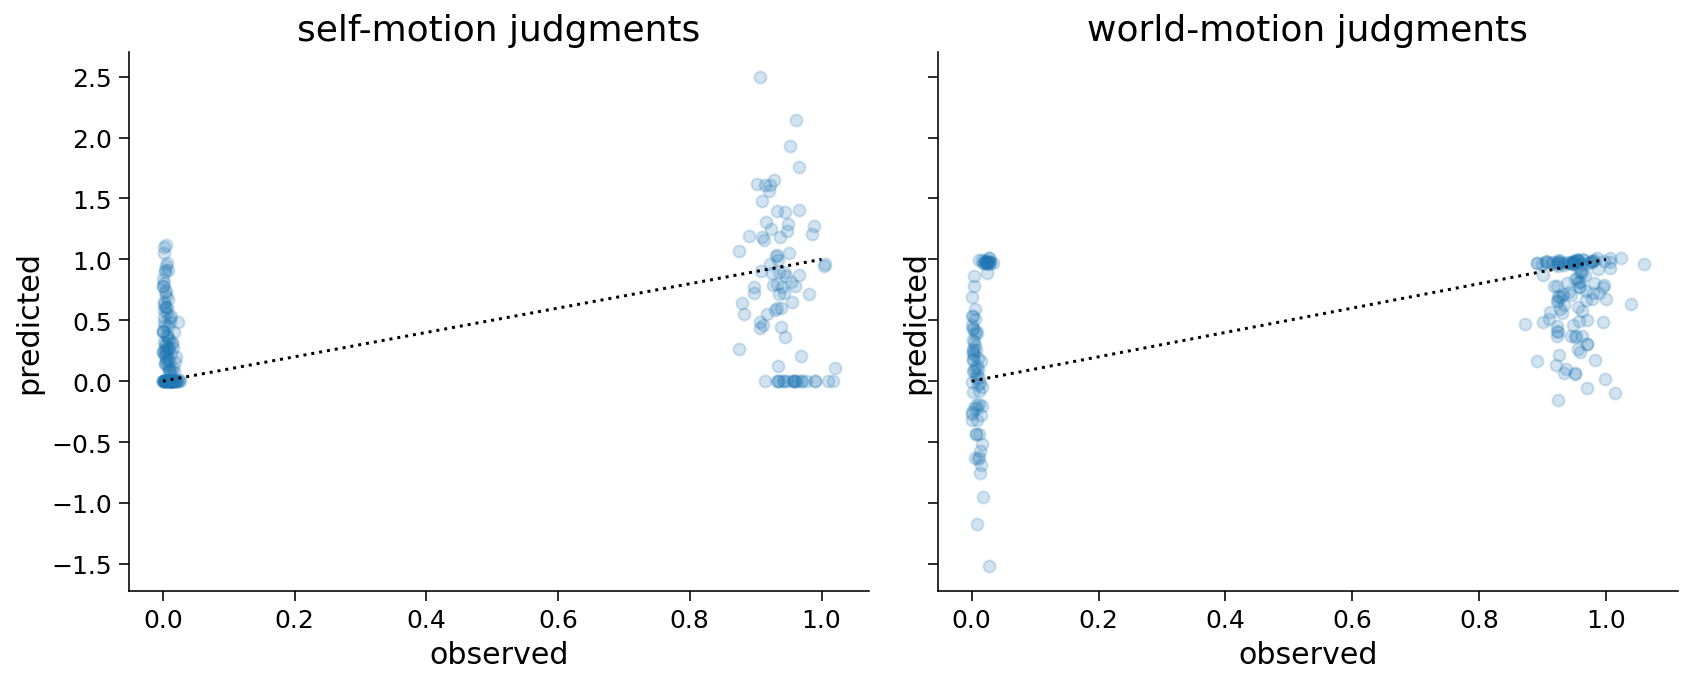

predictions -> judgments R^2: 0.223


In [ ]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

data = {'opticflow': opticflow, 'vestibular': vestibular}


def refresh(threshold=0, windowsize=100):

    # set parameters according to sliders:
    params = {'samplingrate': 10, 'FUN': np.mean}
    params['filterwindows'] = [windowsize, 50]
    params['threshold'] = threshold

    modelpredictions = my_train_illusion_model(sensorydata=data, params=params)

    predictions = np.zeros(judgments.shape)
    predictions[:, 0:3] = judgments[:, 0:3]
    predictions[:, 3] = modelpredictions['selfmotion']
    predictions[:, 4] = modelpredictions['worldmotion'] * -1

    # plot the predictions:
    my_plot_predictions_data(judgments, predictions)

    # calculate R2
    veljudgmnt = np.concatenate((judgments[:, 3], judgments[:, 4]))
    velpredict = np.concatenate((predictions[:, 3], predictions[:, 4]))
    slope, intercept, r_value,\
      p_value, std_err = stats.linregress(veljudgmnt, velpredict)

    print(f"predictions -> judgments R^2: {r_value ** 2:0.3f}")


_ = widgets.interact(refresh, threshold=(-1, 2, .01), windowsize=(1, 100, 1))

Varying the parameters this way, allows you to increase the models' performance in predicting the actual data as measured by $R^2$. This is called model fitting, and will be done better in the coming weeks.

## TD 9.2: Credit assigmnent of self motion

When we look at the figure in **TD 8.1**, we can see a cluster does seem very close to (1,0), just like in the actual data. The cluster of points at (1,0) are from the case where we conclude there is no self motion, and then set the self motion to 0. That value of 0 removes a lot of noise from the world-motion estimates, and all noise from the self-motion estimate. In the other case, where there is self motion, we still have a lot of noise (see also micro-tutorial 4).

Let's change our `my_selfmotion()` function to return a self motion of 1 when the vestibular signal indicates we are above threshold, and 0 when we are below threshold. Edit the function here.

### Exercise 2: function for credit assigment of self motion

In [38]:
def my_selfmotion(ves, params):
    """
    Estimates self motion for one vestibular signal

    Args:
        ves (numpy.ndarray): 1xM array with a vestibular signal
        params (dict): dictionary with named entries:
            see my_train_illusion_model() for details

    Returns:
        (float): an estimate of self motion in m/s
    """

    # integrate signal:
    ves = np.cumsum(ves * (1 / params['samplingrate']))

    # use running window to accumulate evidence:
    selfmotion = my_moving_window(ves, window=params['filterwindows'][0],
                                  FUN=params['FUN'])

    # take the final value as our estimate:
    selfmotion = selfmotion[-1]

    # compare to threshold, set to 0 if lower and else...
    if selfmotion < params['threshold']:
        selfmotion = 0
    ###########################################################################
    # Exercise: Complete credit assignment. Remove the next line to test your function
    else:
       selfmotion = 1

    #raise NotImplementedError("Modify with credit assignment")
    ###########################################################################

    return selfmotion

# Use the updated function to run the model and plot the data
# Uncomment below to test your function 
data = {'opticflow': opticflow, 'vestibular': vestibular}
params = {'threshold': 0.33, 'filterwindows': [100, 50], 'FUN': np.mean}
#modelpredictions = my_train_illusion_model(sensorydata=data, params=params)

predictions = np.zeros(judgments.shape)
predictions[:, 0:3] = judgments[:, 0:3]
predictions[:, 3] = modelpredictions['selfmotion']
predictions[:, 4] = modelpredictions['worldmotion'] * -1
#my_plot_percepts(datasets={'predictions': predictions}, plotconditions=False)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W1D2_ModelingPractice/solutions/W1D2_Tutorial2_Solution_51dce10c.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=560 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/W1D2_Tutorial2_Solution_51dce10c_0.png>



That looks much better, and closer to the actual data. Let's see if the $R^2$ values have improved. Use the optimal values for the threshold and window size that you found previously.

### Interactive Demo: evaluating the model

In [39]:
#@title

#@markdown Make sure you execute this cell to enable the widget!

data = {'opticflow': opticflow, 'vestibular': vestibular}


def refresh(threshold=0, windowsize=100):

    # set parameters according to sliders:
    params = {'samplingrate': 10, 'FUN': np.mean}
    params['filterwindows'] = [windowsize, 50]
    params['threshold'] = threshold

    modelpredictions = my_train_illusion_model(sensorydata=data, params=params)

    predictions = np.zeros(judgments.shape)
    predictions[:, 0:3] = judgments[:, 0:3]
    predictions[:, 3] = modelpredictions['selfmotion']
    predictions[:, 4] = modelpredictions['worldmotion'] * -1

    # plot the predictions:
    my_plot_predictions_data(judgments, predictions)

    # calculate R2
    veljudgmnt = np.concatenate((judgments[:, 3], judgments[:, 4]))
    velpredict = np.concatenate((predictions[:, 3], predictions[:, 4]))
    slope, intercept, r_value,\
      p_value, std_err = stats.linregress(veljudgmnt, velpredict)

    print(f"predictions -> judgments R2: {r_value ** 2:0.3f}")


_ = widgets.interact(refresh, threshold=(-1, 2, .01), windowsize=(1, 100, 1))

interactive(children=(FloatSlider(value=0.0, description='threshold', max=2.0, min=-1.0, step=0.01), IntSlider…

While the model still predicts velocity judgments better than the conditions (i.e. the model predicts illusions in somewhat similar cases), the $R^2$ values are a little worse than those of the simpler model. What's really going on is that the same set of points that were model prediction errors in the previous model are also errors here. All we have done is reduce the spread.

**Interpret the model's meaning**

Here's what you should have learned from model the train illusion: 

1. A noisy, vestibular, acceleration signal can give rise to illusory motion.
2. However, disambiguating the optic flow by adding the vestibular signal simply adds a lot of noise. This is not a plausible thing for the brain to do.
3. Our other hypothesis - credit assignment - is more qualitatively correct, but our simulations were not able to match the frequency of the illusion on a trial-by-trial basis.

We decided that for now we have learned enough, so it's time to write it up.


---
# Section 10: Model publication!

Video available at https://youtube.com/watch?v=zm8x7oegN6Q


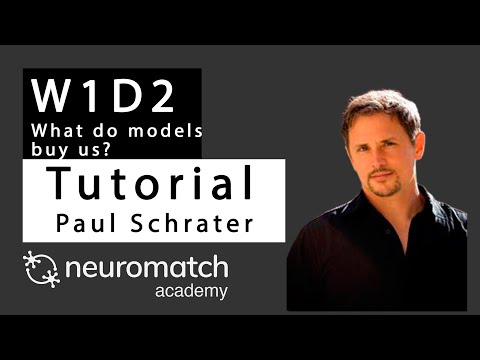

In [ ]:
# @title Video 10: Publication
video = YouTubeVideo(id='zm8x7oegN6Q', width=854, height=480, fs=1)
print(f"Video available at https://youtube.com/watch?v={video.id}")
video


**Goal:** In order for our model to impact the field, it needs to be accepted by our peers, and order for that to happen it matters how the model is published.

## TD 10.1: Write a summary of the project

Here we will write up our model, by answering the following questions:
* **What is the phenomena**?  Here summarize the part of the phenomena which your model addresses.
* **What is the key scientific question?**:  Clearly articulate the question which your model tries to answer.
* **What was our hypothesis?**:  Explain the key relationships which we relied on to simulate the phenomena.
* **How did your model work?** Give an overview of the model, it's main components, and how the model works.  ''Here we ... ''
* **What did we find? Did the model work?** Explain the key outcomes of your model evaluation. 
* **What can we conclude?** Conclude as much as you can _with reference to the hypothesis_, within the limits of the model.  
* **What did you learn? What is left to be learned?** Briefly argue the plausibility of the approach and what you think is _essential_ that may have been left out.

### Guidance for the future
There are good guidelines for structuring and writing an effective paper (e.g., [Mensh & Kording, 2017](https://doi.org/10.1371/journal.pcbi.1005619)), all of which apply to papers about models. There are some extra considerations when publishing a model. In general, you should explain each of the steps in the paper:

**Introduction:** Steps 1 & 2 (maybe 3)

**Methods:** Steps 3-7, 9

**Results:** Steps 8 & 9, going back to 1, 2 & 4

In addition, you should provide a visualization of the model, and upload the code implementing the model and the data it was trained and tested on to a repository (e.g. GitHub and OSF).

The audience for all of this should be experimentalists, as they are the ones who can test predictions made by your your model and collect new data. This way your models can impact future experiments, and that future data can then be modeled (see modeling process schematic below). Remember your audience - it is _always_ hard to clearly convey the main points of your work to others, especially if your audience doesn't necessarily create computational models themselves.

![how-to-model process from Blohm et al 2019](https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W1D2_ModelingPractice/static/NMA-W1D2-fig06.png)

### Suggestion

For every modeling project, a very good exercise in this is to _**first**_ write a short, 100-word abstract of the project plan and expected impact, like the summary you wrote. This forces focussing on the main points: describing the relevance, question, model, answer and what it all means very succinctly. This allows you to decide to do this project or not **before you commit time writing code for no good purpose**. Notice that this is really what we've walked you through carefully in this tutorial! :)


---
# Summary
Confatulations! You have finished Day2 of NMA! In this tutorial, we worked through the rest steps of the process of modeling.

- We identified the key components of the model, and examined how they work together (step 6)
- We implemented the model (step 7), and completed it (step 8)
- We tested and evaluated our model (step 9), and finally
- We learn how to publish our model in order to increase its visibility amongts our peers

## Post-script

Note that the model we built here was extremely simple and used artificial data on purpose. It allowed us to go through all the steps of building a model, and hopefully you noticed that it is not always a linear process, you will go back to different steps if you hit a roadblock somewhere.

However, if you're interested in how to actually approach modeling a similar phenomenon in a probabilistic way, we encourage you to read the paper by [Dokka et. al., 2019](https://doi.org/10.1073/pnas.1820373116), where the authors model how judgments of heading direction are influenced by objects that are also moving.

---
# Reading

Blohm G, Kording KP, Schrater PR (2020). _A How-to-Model Guide for Neuroscience_ eNeuro, 7(1). https://doi.org/10.1523/ENEURO.0352-19.2019 

Dokka K, Park H, Jansen M, DeAngelis GC, Angelaki DE (2019). _Causal inference accounts for heading perception in the presence of object motion._ PNAS, 116(18):9060-9065. https://doi.org/10.1073/pnas.1820373116

Drugowitsch J, DeAngelis GC, Klier EM, Angelaki DE, Pouget A (2014). _Optimal Multisensory Decision-Making in a Reaction-Time Task._ eLife, 3:e03005. https://doi.org/10.7554/eLife.03005

Hartmann, M, Haller K, Moser I, Hossner E-J, Mast FW  (2014). _Direction detection thresholds of passive self-motion in artistic gymnasts._ Exp Brain Res, 232:1249–1258. https://doi.org/10.1007/s00221-014-3841-0

Mensh B, Kording K (2017). _Ten simple rules for structuring papers._ PLOS Comput Biol 13(9): e1005619. https://doi.org/10.1371/journal.pcbi.1005619

Seno T, Fukuda H (2012). _Stimulus Meanings Alter Illusory Self-Motion (Vection) - Experimental Examination of the Train Illusion._ Seeing Perceiving, 25(6):631-45. https://doi.org/10.1163/18784763-00002394
